In [36]:
import torch
from transformers import SamProcessor, SamModel
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import transformers
import requests
from io import BytesIO
import warnings
from huggingface_hub import snapshot_download
from pathlib import Path
import os, sys
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version: {torch.__version__}, using device: {device}")
print(f"transformers version: {transformers.__version__}")



torch version: 2.6.0+cu124, using device: cuda
transformers version: 4.52.4


In [37]:

if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    HF_MODELS_DIR = Path("/content/drive/MyDrive/hf_models")
else:
    HF_MODELS_DIR = Path(r"G:\Mi unidad\hf_models")

HF_MODELS_DIR.mkdir(parents=True, exist_ok=True)

models = [
    "IDEA-Research/grounding-dino-base",
    "facebook/sam-vit-large",
    "openai/clip-vit-base-patch32",
    "Salesforce/blip-image-captioning-base"
]

for repo in models:
    local_dir = HF_MODELS_DIR / repo
    snapshot_download(
        repo_id=repo,
        local_dir=str(local_dir),
        local_dir_use_symlinks=False,
        resume_download=True
)

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
# models
dino_path = HF_MODELS_DIR / "IDEA-Research/grounding-dino-base"
dino_processor = AutoProcessor.from_pretrained(dino_path)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_path).to(device)

sam_path = HF_MODELS_DIR / "facebook/sam-vit-large"
sam_processor = SamProcessor.from_pretrained(sam_path)
sam_model = SamModel.from_pretrained(sam_path).to(device)

clip_path = HF_MODELS_DIR / "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_path)
clip_model = CLIPModel.from_pretrained(clip_path).to(device)

blip_path = HF_MODELS_DIR / "Salesforce/blip-image-captioning-base"
blip_processor = BlipProcessor.from_pretrained(blip_path)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_path, torch_dtype=torch.float16).to(device)

In [39]:
# images
url_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/cars.jpg"
image_cars = Image.open(BytesIO(requests.get(url_cars).content)).convert("RGB")

url_person_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/person_cars.jpg"
image_person_cars = Image.open(BytesIO(requests.get(url_person_cars).content)).convert("RGB")

url_fruits = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/fruits.jpg"
image_fruits = Image.open(BytesIO(requests.get(url_fruits).content)).convert("RGB")

'a photo of a street with a person' -> Probability: 0.93
'a photo of a dog' -> Probability: 0.00
'a photo of several cars but without any person on it' -> Probability: 0.07


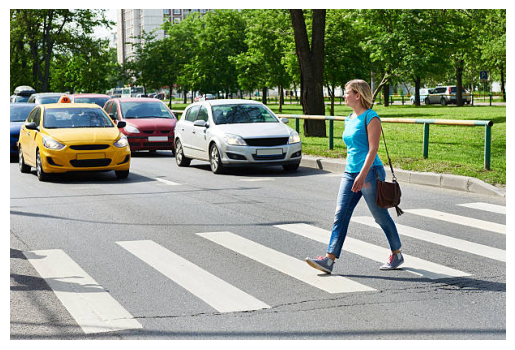

In [9]:
# clip

image = image_person_cars
descriptions = ["a photo of a street with a person", "a photo of a dog", "a photo of several cars but without any person on it"]

inputs = clip_processor(text=descriptions, images=image, return_tensors="pt", padding=True).to(device)

outputs = clip_model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

for desc, prob in zip(descriptions, probs[0].tolist()):
    print(f"'{desc}' -> Probability: {prob:.2f}")
    
plt.imshow(image)
plt.axis("off")
plt.show()

In [42]:
#Blip
image = image_person_cars
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)

out = blip_model.generate(**inputs)
print(blip_processor.decode(out[0], skip_special_tokens=True))


a woman walking across a crosswalk in a city


Box: tensor([  9.1007, 114.1038, 150.1338, 211.9607], device='cuda:0'), Label: yellow car, Score: 0.9335060119628906


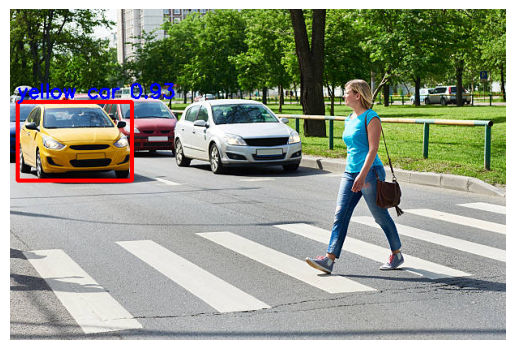

In [21]:
# gounding dino

image = image_person_cars
prompt = ["yellow car"]

# image = image_fruits
# prompt = ["kiwi", "orange"]

w, h = image.size
scale = min(768 / max(h, w), 1.0)
new_h, new_w = int(h * scale), int(w * scale)

# Aplicar Grounding DINO - procesamiento directo
inputs = dino_processor(
    images=image,
    text=prompt,
    return_tensors="pt",
    do_resize=True,
    size={"height": new_h, "width": new_w}
).to(device)

# Ejecutar DINO para detección
with torch.no_grad():
    outputs = dino_model(**inputs)

results = dino_processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            threshold=0.7,
            text_threshold=0.7,
            target_sizes=[(h, w)])

boxes = results[0]['boxes']
labels = results[0]['labels']
scores = results[0]['scores']

# Mostrar resultados
for box, label, score in zip(boxes, labels, scores):
    print(f"Box: {box}, Label: {label}, Score: {score}")


img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
for box, label, score in zip(boxes, labels, scores):
    x0, y0, x1, y1 = map(int, box)
    cv2.rectangle(img_cv, (x0, y0), (x1, y1), (0,0,255), 3)
    txt = f"{label} {score:.2f}"
    cv2.putText(img_cv, txt, (x0, y0-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


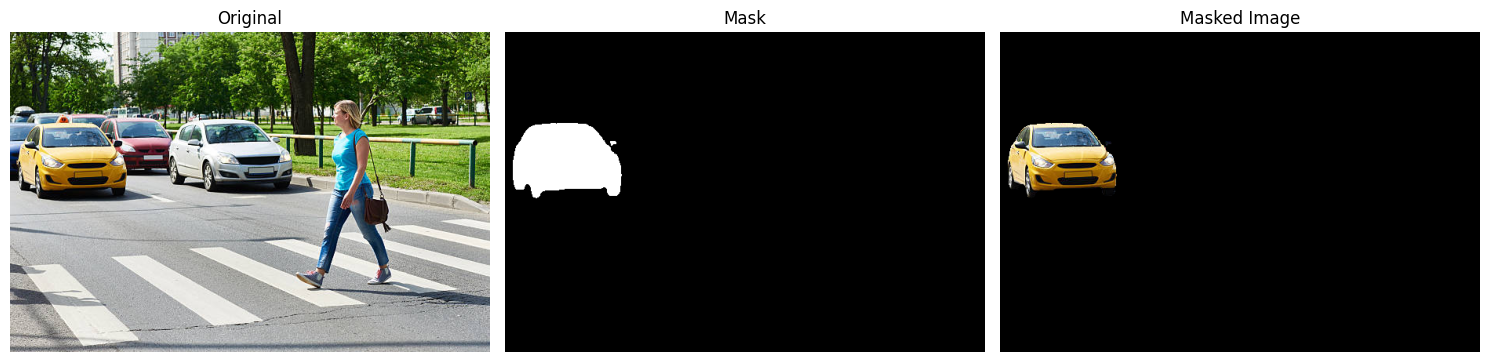

In [24]:
# sam
image = image_person_cars
box = [9.1007, 114.1038, 150.1338, 211.9607]

inputs = sam_processor(images=image, input_boxes=[[box]], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.post_process_masks(outputs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"])
best_mask = masks[0][0][outputs.iou_scores.argmax()].cpu().numpy()


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(best_mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
masked_img = np.array(image) * best_mask[:,:,None]
axes[2].imshow(masked_img.astype(np.uint8))
axes[2].set_title("Masked Image")
axes[2].axis("off")
plt.tight_layout()
plt.show()

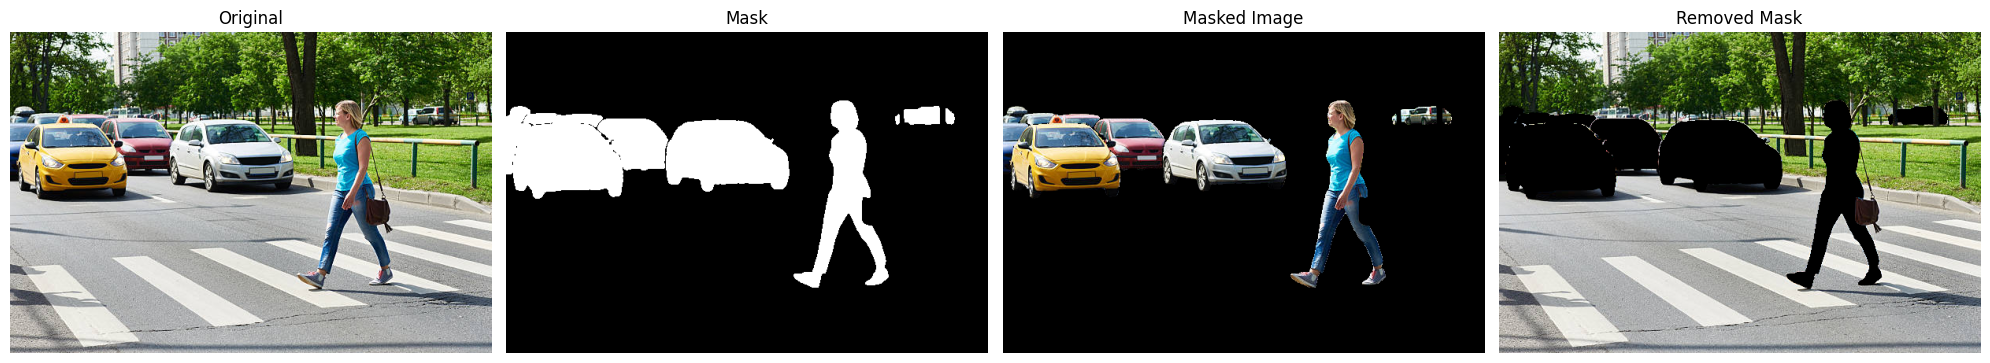

In [32]:
# dino + sam
image = image_person_cars
prompt = ["cars", "woman"]

BATCH_MODE = True

w, h = image.size
scale = min(768 / max(h, w), 1.0)
new_h, new_w = int(h * scale), int(w * scale)

inputs = dino_processor(images=image, text=prompt, return_tensors="pt", do_resize=True, size={"height": new_h, "width": new_w}).to(device)

with torch.no_grad():
    outputs = dino_model(**inputs)

results = dino_processor.post_process_grounded_object_detection( outputs, inputs.input_ids, threshold=0.3, text_threshold=0.5, target_sizes=[(h, w)])

boxes = results[0]['boxes'].cpu().numpy().tolist()
scores = results[0]['scores'].cpu().numpy().tolist()
labels = results[0]['labels']

final_mask = np.zeros((h, w), dtype=np.float32)

if not BATCH_MODE:
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        sam_inputs = sam_processor(images=image, input_boxes=[[box]], return_tensors="pt").to(device)

        with torch.no_grad():
            sam_outputs = sam_model(**sam_inputs)

        masks = sam_processor.post_process_masks(sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"])
        best_mask = masks[0][0][sam_outputs.iou_scores.argmax()].cpu().numpy()
        final_mask += best_mask

else:
    if len(boxes) > 0:
        sam_inputs = sam_processor(images=image, input_boxes=[boxes], return_tensors="pt").to(device)

        with torch.no_grad():
            sam_outputs = sam_model(**sam_inputs)

        masks = sam_processor.post_process_masks(sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"])
        iou_scores = sam_outputs.iou_scores.cpu().numpy()
        final_mask = np.zeros((h, w), dtype=np.float32)

        for i in range(len(boxes)):
            detection_masks = masks[0][i].cpu().numpy()
            best_idx = iou_scores[0][i].argmax()
            final_mask += detection_masks[best_idx]


final_mask = np.clip(final_mask, 0, 1)


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(final_mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
masked_img = np.array(image) * final_mask[:,:,None]
axes[2].imshow(masked_img.astype(np.uint8))
axes[2].set_title("Masked Image")
axes[2].axis("off")
inverted_mask = 1 - final_mask
removed_img = np.array(image) * inverted_mask[:,:,None]
axes[3].imshow(removed_img.astype(np.uint8))
axes[3].set_title("Removed Mask")
axes[3].axis("off")
plt.tight_layout()
plt.show()